In [96]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

from matplotlib import pyplot
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
import seaborn
import pandas as pd
import random
import csv
import re

In [97]:
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

In [98]:
with open("../data/chembl_mtor_ic50.csv") as inp:
    mtor = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in mtor:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["source"] = "mtor"
        m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0

In [99]:
%%capture
# %%capture hides stderr (and maybe all stdoutput)
drugbank = [{"rdmol": m, "source": "drugbank", "Smiles": Chem.MolToSmiles(m), "pChEMBL Value": 0} for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m]

In [100]:
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

data = [[mol["Smiles"], mol["source"], mol["rdmol"], mol["pChEMBL Value"], *(f[1](mol["rdmol"]) for f in lip_func)] for mol in (*mtor, *drugbank)]

In [102]:
df = pd.DataFrame(data, columns=["Smiles", "source", "rdmol", "pChEMBL Value", "HBA", "HBD", "MW", "LogP", "TPSA", "RB"])

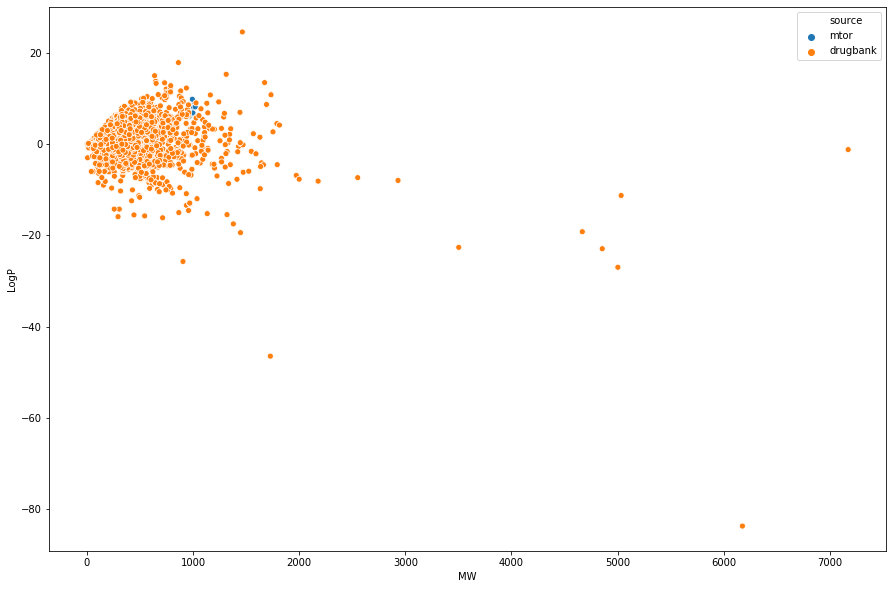

In [105]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MW", y="LogP", data=df, hue="source", legend="brief", ax=ax)

In [106]:
mqns = [rdMolDescriptors.MQNs_(mol["rdmol"]) for mol in (*mtor, *drugbank)]

In [108]:
df = df.join(pd.DataFrame(mqns, columns=[*(f"MQN_{x}" for x in range(1,43))]))

In [111]:
pca = decomposition.PCA(n_components=42)
pca.fit(df[(f"MQN_{x}" for x in range(1, 43))])
t_data = pca.transform(df[(f"MQN_{x}" for x in range(1, 43))])
t_frame = pd.DataFrame(t_data, columns=[f"PCA_{x}" for x in range(1, 43)])
df = df.join(t_frame)

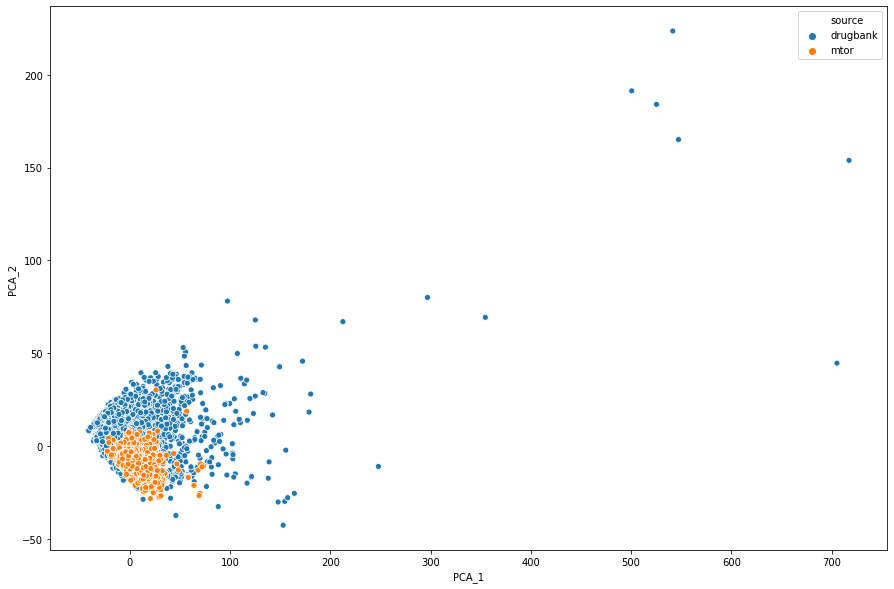

In [125]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1", y="PCA_2",data=df.iloc[::-1], hue="source",legend="brief", ax=ax)

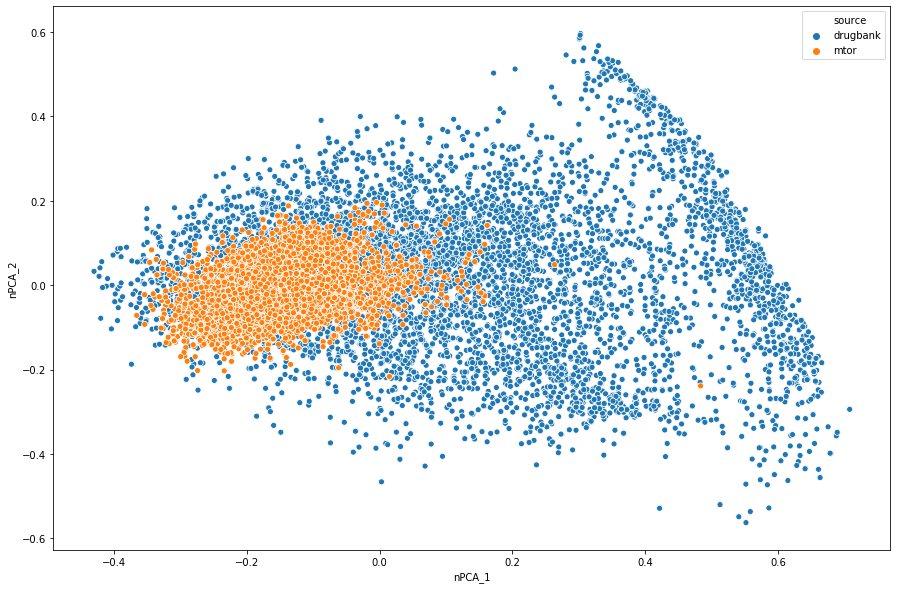

In [124]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
t_data = pca.transform(norm)
t_frame = pd.DataFrame(t_data, columns=[f"nPCA_{x}" for x in range(1, 43)])
tmp = df.join(t_frame)
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1", y="nPCA_2",data=tmp.iloc[::-1], hue="source",legend="brief", ax=ax)

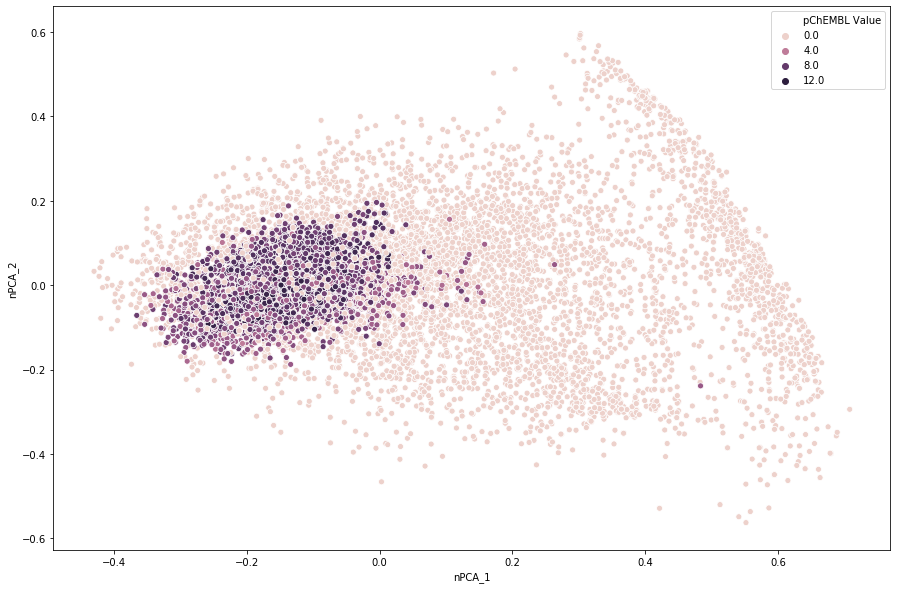

In [127]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1", y="nPCA_2",data=tmp.iloc[::-1], hue="pChEMBL Value",legend="brief", ax=ax)

https://en.wikipedia.org/wiki/Multidimensional_scaling

In [136]:
fps = [Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024) for m in (*mtor, *drugbank)]

sparse_mat = distance.pdist(fps,metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [137]:
mds_frame = pd.DataFrame(X_mds, columns=["x","y"]).join(df)

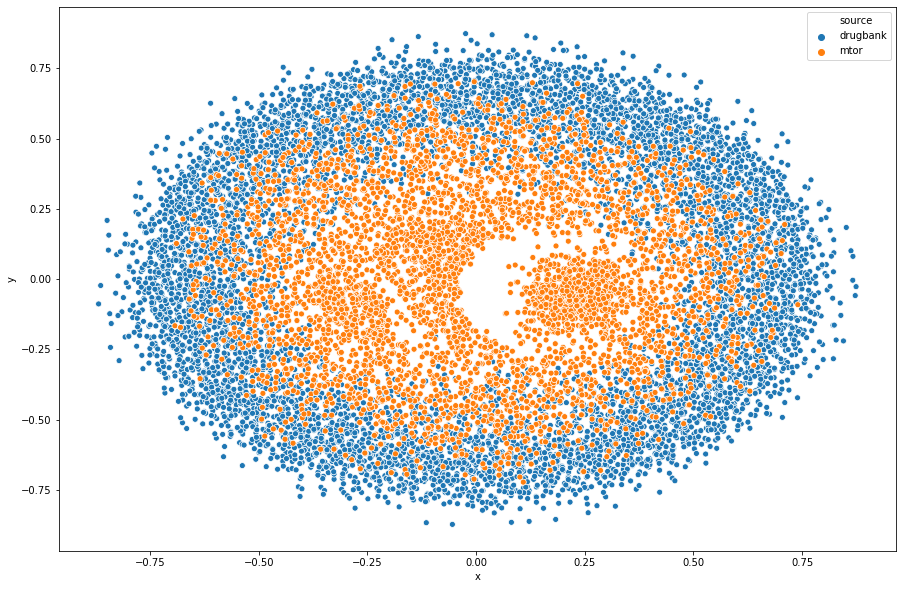

In [140]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="x", y="y", data=mds_frame.iloc[::-1], hue="source", legend="brief", ax=ax)

https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [142]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)

In [143]:
tsne_frame = pd.DataFrame(X_tsne, columns=["x","y"]).join(df)

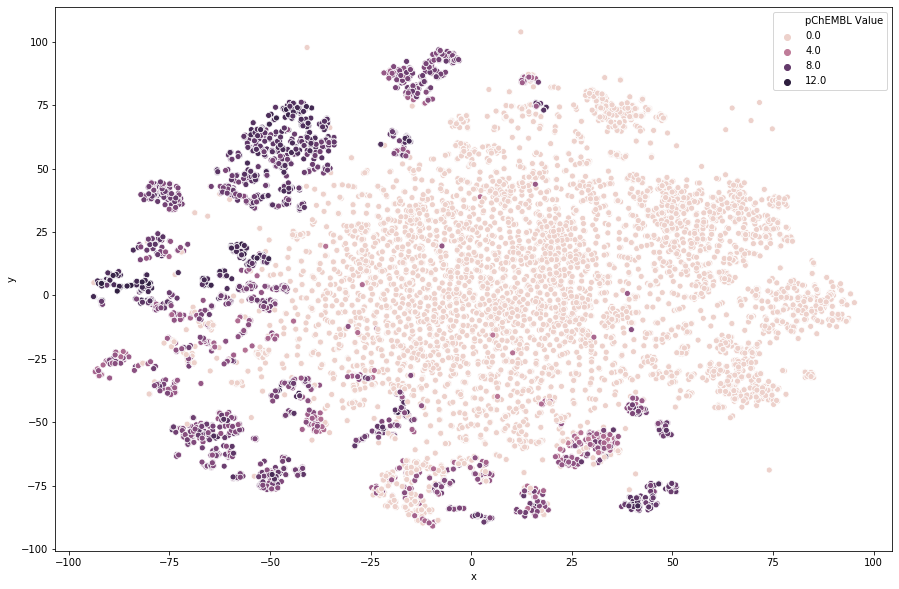

In [145]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="x", y="y", data=tsne_frame.iloc[::-1], hue="pChEMBL Value", legend="brief", ax=ax)

GPS
http://chemgps.bmc.uu.se/batchelor/queue/submit